# Importing Libraries

In [1]:
import os
import pandas as panda
import kagglehub
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt


# Download and Load the Dataset

In [3]:
# ---------- DOWNLOAD AND LOAD DATASET ----------

# Download the dataset
path = kagglehub.dataset_download("PromptCloudHQ/imdb-data")
print("Path to dataset files:", path)

# List all files in the dataset
files = os.listdir(path)
print("Files in the dataset:", files)

# Load the CSV file
csvFilePath = os.path.join(path, 'IMDB-Movie-Data.csv')
data = panda.read_csv(csvFilePath)

# Display Columns and Sample Data
print(data.columns)
print(data['Title'][1])
print(data['Genre'][1])
print(data['Description'][1])

Path to dataset files: /root/.cache/kagglehub/datasets/PromptCloudHQ/imdb-data/versions/1
Files in the dataset: ['IMDB-Movie-Data.csv']
Index(['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year',
       'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)',
       'Metascore'],
      dtype='object')
Prometheus
Adventure,Mystery,Sci-Fi
Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.


# Preprocess the Text Data

In [4]:
# ---------- PREPROCESS THE DATA ----------

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize stopwords and lemmatizer
stopWords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text
def preprocessText(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stopwords and non-alphanumeric tokens, and lemmatize remaining tokens
    filteredTokens = [lemmatizer.lemmatize(token) for token in
                      tokens if token not in stopWords and token.isalnum()]
    return ' '.join(filteredTokens)

# Apply preprocessing to the 'Description' column
data['CleanedDescription'] = data['Description'].apply(preprocessText)

# Display the cleaned description
print(data['CleanedDescription'][1])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


following clue origin mankind team find structure distant moon soon realize alone


# Tokenize and Padding Sequences

In [5]:
# ---------- TOKENIZE TEXT DATA AND PAD SEQUENCES ----------

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['CleanedDescription'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['CleanedDescription'])

# Define max sequence length
maxSeqLength = 100

# Pad the sequences
paddedSequences = pad_sequences(sequences, maxlen=maxSeqLength)

# Load GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# Create embedding index
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embeddingDim = 100
wordIndex = tokenizer.word_index
embeddingMatrix = np.zeros((len(wordIndex) + 1, embeddingDim))
for word, i in wordIndex.items():
    embeddingVector = embeddings_index.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i] = embeddingVector

# Print statements
print ('Found %s word vectors.' % len(embeddings_index))
print('Shape of embedding matrix:', embeddingMatrix.shape)
print('Shape of padded sequences:', paddedSequences.shape)


--2024-11-17 19:26:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-17 19:26:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-17 19:26:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

gl

# Preprocess Labels

In [6]:
# ---------- PREPROCESS LABELS ----------

# Split genres into list of genres
data['GenreList'] = data['Genre'].apply(lambda x: x.split(','))

# Print genre list
print(data['GenreList'])

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the genres
genresEncoded = mlb.fit_transform(data['GenreList'])

# Display encoded genres and classes
print(genresEncoded[0])
print(mlb.classes_)

0       [Action, Adventure, Sci-Fi]
1      [Adventure, Mystery, Sci-Fi]
2                [Horror, Thriller]
3       [Animation, Comedy, Family]
4      [Action, Adventure, Fantasy]
                   ...             
995         [Crime, Drama, Mystery]
996                        [Horror]
997         [Drama, Music, Romance]
998             [Adventure, Comedy]
999       [Comedy, Family, Fantasy]
Name: GenreList, Length: 1000, dtype: object
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']


# Split Data (Train, Validate, Test)

In [7]:
# ---------- SPLIT DATA INTO TRAINING (700), VALIDATION (100), TEST (200) SETS ----------

# Split the data into training, validation, and test sets

# XTrain = Training Features
# XTemp = Temporary Features
# YTrain = Training Target
# YTemp = Temporary Target
# XVal = Validation Features
# XTest = Testing Features
# YVal = Validation Target
# YTest = Testing Target
XTrain, XTemp, YTrain, YTemp = train_test_split(paddedSequences, genresEncoded, train_size=700, random_state=88)
XVal, XTest, YVal, YTest = train_test_split(XTemp, YTemp, test_size=200, random_state=88)

print('Training set shape:', XTrain.shape, YTrain.shape)
print('Validation set shape:', XVal.shape, YVal.shape)
print('Test set shape:', XTest.shape, YTest.shape)

Training set shape: (700, 100) (700, 20)
Validation set shape: (100, 100) (100, 20)
Test set shape: (200, 100) (200, 20)


# Create Data Loaders

In [8]:
# ---------- CREATE DATALOADERS ----------

# Create data loaders
trainDataset = tf.data.Dataset.from_tensor_slices((XTrain, YTrain)).batch(32)
valDataset = tf.data.Dataset.from_tensor_slices((XVal, YVal)).batch(32)
testDataset = tf.data.Dataset.from_tensor_slices((XTest, YTest)).batch(32)

# Build and Train the RNN Model

In [9]:
# ---------- BUILD AND TRAIN THE RNN MODEL ----------

# Build RNN Model
rnnModel = Sequential([
    Embedding(input_dim=len(wordIndex) + 1, output_dim=embeddingDim,
              weights=[embeddingMatrix], input_length=maxSeqLength,
              trainable=False),
    SimpleRNN(128, return_sequences=True),
    SimpleRNN(128),
    Dense(20, activation='sigmoid')
])

# Compile the model
rnnModel.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train the model
historyRnn = rnnModel.fit(trainDataset, validation_data=valDataset,
                          epochs=20)

# Evaluate the model
print("RNN Test Set Model Evaluation:")
rnnModel.evaluate(testDataset)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.1525 - loss: 0.4977 - val_accuracy: 0.1600 - val_loss: 0.3067
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.2228 - loss: 0.3154 - val_accuracy: 0.1600 - val_loss: 0.3020
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.2250 - loss: 0.3109 - val_accuracy: 0.1500 - val_loss: 0.3010
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.2455 - loss: 0.3022 - val_accuracy: 0.2200 - val_loss: 0.2990
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.3169 - loss: 0.2880 - val_accuracy: 0.2500 - val_loss: 0.2959
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3485 - loss: 0.2734 - val_accuracy: 0.3600 - val_loss: 0.2841
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3776 - loss: 0.2547 - val_accuracy: 0.3100 - val_loss: 0.2953
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3764 - loss: 0.2398 - val_accuracy: 0.3700 - val_los

[0.38172152638435364, 0.3149999976158142]

# Build and Train LSTM Model

In [10]:
# ---------- BUILD AND TRAIN THE LSTM MODEL ----------

# Build LSTM Model

lstmModel = Sequential([
    Embedding(input_dim=len(wordIndex) + 1, output_dim=embeddingDim,
              weights = [embeddingMatrix], trainable = False),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(20, activation='sigmoid')
])

# Compile the model
lstmModel.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
historyLSTM = lstmModel.fit(trainDataset, validation_data=valDataset,
                            epochs=20)

# Evaluate the model
print("LSTM Test Set Model Evaluation:")
lstmModel.evaluate(testDataset)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - accuracy: 0.1658 - loss: 0.5151 - val_accuracy: 0.1600 - val_loss: 0.3025
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - accuracy: 0.2228 - loss: 0.3162 - val_accuracy: 0.1600 - val_loss: 0.3003
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.2228 - loss: 0.3153 - val_accuracy: 0.1600 - val_loss: 0.2944
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.2303 - loss: 0.3075 - val_accuracy: 0.2200 - val_loss: 0.2842
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.2974 - loss: 0.2954 - val_accuracy: 0.2000 - val_loss: 0.2684
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 447ms/step - accuracy: 0.2822 - loss: 0.2851 - val_accuracy: 0.3200 - val_loss: 0.2654
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.3034 - loss: 0.2749 - val_accuracy: 0.3600 - val_loss: 0.2702
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - accuracy: 0.3410 - loss: 0.2660 - val_accuracy

[0.2945426404476166, 0.3499999940395355]

# Plot Results

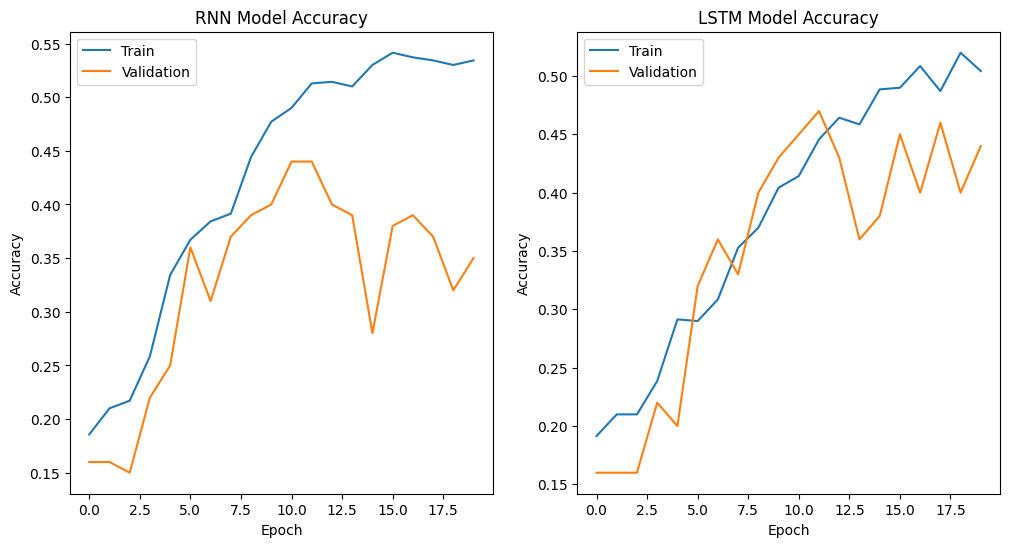

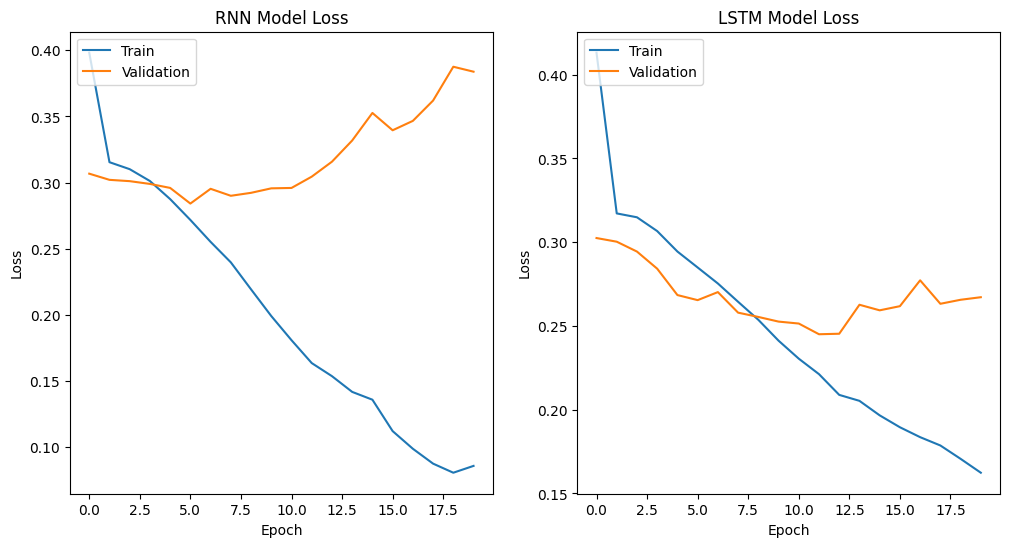

In [11]:
# ---------- PLOT RESULTS ----------

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(historyRnn.history['accuracy'])
plt.plot(historyRnn.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(historyLSTM.history['accuracy'])
plt.plot(historyLSTM.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(historyRnn.history['loss'])
plt.plot(historyRnn.history['val_loss'])
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(historyLSTM.history['loss'])
plt.plot(historyLSTM.history['val_loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Report the Results

In [12]:
# ---------- REPORT THE RESULTS ----------

# Evaluate the RNN model on the test set
rnnTestLoss, rnnTestAccuracy = rnnModel.evaluate(testDataset)
print(f'RNN Model - Test Loss: {round(rnnTestLoss, 2)}, Test Accuracy: {round(rnnTestAccuracy, 2)}')

# Evaluate the LSTM model on the test set
OldLstmTestLoss, OldLstmTestAccuracy = lstmModel.evaluate(testDataset)
print(f'LSTM Model - Test Loss: {round(OldLstmTestLoss, 2)}, Test Accuracy: {round(OldLstmTestAccuracy, 2)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3179 - loss: 0.3789
RNN Model - Test Loss: 0.38, Test Accuracy: 0.31
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3798 - loss: 0.2857
LSTM Model - Test Loss: 0.29, Test Accuracy: 0.35


# Add Titles to Text Description

In [13]:
# ---------- ADD TITLES TO TEXT DESCRIPTION ----------

# Combine titles and descriptions
data['TitleDescription'] = data['Title'] + ' ' + data['CleanedDescription']

# Tokenize the combined text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['TitleDescription'])
sequences = tokenizer.texts_to_sequences(data['TitleDescription'])

# Pad the sequences
maxSeqLength = 100
paddedSequences = pad_sequences(sequences, maxlen=maxSeqLength)

# Create an embedding matrix based on the updated word index
wordIndex = tokenizer.word_index
embeddingMatrix = np.zeros((len(wordIndex) + 1, embeddingDim))
for word, i in wordIndex.items():
    embeddingVector = embeddings_index.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i] = embeddingVector

# Split the data into training, validation, and test sets
XTrain, XTemp, YTrain, YTemp = train_test_split(paddedSequences, genresEncoded,
                                                train_size=700, random_state=88)
XVal, XTest, YVal, YTest = train_test_split(XTemp, YTemp, test_size=200,
                                            random_state=88)

# Create data loaders
trainDataset = tf.data.Dataset.from_tensor_slices((XTrain, YTrain)).batch(32)
valDataset = tf.data.Dataset.from_tensor_slices((XVal, YVal)).batch(32)
testDataset = tf.data.Dataset.from_tensor_slices((XTest, YTest)).batch(32)

# Build LSTM Model
lstmModel = Sequential([
    Embedding(input_dim=len(wordIndex) + 1, output_dim=embeddingDim,
              weights=[embeddingMatrix], trainable=False),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(20, activation='sigmoid')
])

# Compile the model
lstmModel.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
historyLSTM = lstmModel.fit(trainDataset, validation_data=valDataset,
                            epochs=20)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - accuracy: 0.1850 - loss: 0.5238 - val_accuracy: 0.1600 - val_loss: 0.3041
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.2228 - loss: 0.3193 - val_accuracy: 0.1600 - val_loss: 0.3013
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.2228 - loss: 0.3170 - val_accuracy: 0.1600 - val_loss: 0.3004
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.2228 - loss: 0.3152 - val_accuracy: 0.1600 - val_loss: 0.2960
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.2281 - loss: 0.3088 - val_accuracy: 0.4200 - val_loss: 0.2818
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 384ms/step - accuracy: 0.3375 - loss: 0.2947 - val_accuracy: 0.4100 - val_loss: 0.2685
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - accuracy: 0.3392 - loss: 0.2861 - val_accuracy: 0.2400 - val_loss: 0.2649
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.3045 - loss: 0.2792 - val_accurac

# Report New Results

In [15]:
# ---------- PRINT NEW RESULTS ----------

# Evaluate the model
print("LSTM Test Set Model Evaluation:")
lstmTestLoss, lstmTestAccuracy = lstmModel.evaluate(testDataset)

# Print the test loss and accuracy
print(f'LSTM Model without Titles - Test Loss: {round(OldLstmTestLoss, 2)}, Test Accuracy: {round(OldLstmTestAccuracy, 2)}')
print(f'LSTM Model with Titles - Test Loss: {round(lstmTestLoss, 2)}, Test Accuracy: {round(lstmTestAccuracy, 2)}')

LSTM Test Set Model Evaluation:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3103 - loss: 0.2999
LSTM Model without Titles - Test Loss: 0.29, Test Accuracy: 0.35
LSTM Model with Titles - Test Loss: 0.31, Test Accuracy: 0.29


## Model Performance Report

### LSTM Model without Titles
- Test Loss: 0.29
- Test Accuracy: 0.35

### LSTM Model with Titles
- Test Loss: 0.31
- Test Accuracy: 0.29

### Comparison
Adding titles to the text descriptions did not improve the model's performance. The accuracy without titles was 0.35, while the accuracy with titles was 0.29. Because of this, I assume that adding titles to the text description may make it more complex to determine the correct genre.